In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df=pd.read_csv('flights.csv', low_memory=False)
print('Dataframe dimensions:', df.shape)

Dataframe dimensions: (5819079, 31)


In [3]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5819079 entries, 0 to 5819078
Data columns (total 31 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   YEAR                 5819079 non-null  int64  
 1   MONTH                5819079 non-null  int64  
 2   DAY                  5819079 non-null  int64  
 3   DAY_OF_WEEK          5819079 non-null  int64  
 4   AIRLINE              5819079 non-null  object 
 5   FLIGHT_NUMBER        5819079 non-null  int64  
 6   TAIL_NUMBER          5804358 non-null  object 
 7   ORIGIN_AIRPORT       5819079 non-null  object 
 8   DESTINATION_AIRPORT  5819079 non-null  object 
 9   SCHEDULED_DEPARTURE  5819079 non-null  int64  
 10  DEPARTURE_TIME       5732926 non-null  float64
 11  DEPARTURE_DELAY      5732926 non-null  float64
 12  TAXI_OUT             5730032 non-null  float64
 13  WHEELS_OFF           5730032 non-null  float64
 14  SCHEDULED_TIME       5819073 non-null  float64
 15

In [4]:
df.sample(20)

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
2944753,2015,7,4,6,DL,1160,N998AT,IAD,ATL,1225,...,1401.0,-19.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2280902,2015,5,25,1,UA,1252,N24211,ORD,MCO,1430,...,1815.0,4.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
133157,2015,1,9,5,MQ,3463,N530MQ,RDU,LGA,1236,...,1537.0,88.0,0,0,NaN,88.0,0.0,0.0,0.0,0.0
4449079,2015,10,5,1,WN,581,N762SW,14193,10693,700,...,811.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3870002,2015,8,28,5,WN,1897,N963WN,AUS,OAK,1700,...,1841.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
540180,2015,2,5,4,MQ,3639,N682MQ,JFK,CMH,1530,...,1719.0,-11.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2397469,2015,6,1,1,MQ,3031,N661MQ,BMI,ORD,1645,...,1722.0,-20.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3498717,2015,8,6,4,WN,4367,N215WN,BOS,DEN,930,...,1222.0,17.0,0,0,NaN,17.0,0.0,0.0,0.0,0.0
3945322,2015,9,2,3,UA,1431,N57862,LAX,HNL,1330,...,1603.0,-17.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1828112,2015,4,27,1,DL,1134,N694DL,PBI,ATL,1100,...,1245.0,-2.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Each entry of the flights.csv file corresponds to a flight and we see that more than 5'800'000 flights have been recorded in 2015. These flights are described according to 31 variables. A description of these variables can be found here and I briefly recall the meaning of the variables that will be used in this notebook:

# YEAR, MONTH, DAY, DAY_OF_WEEK: dates of the flight
# AIRLINE: An identification number assigned by US DOT to identify a unique airline
# ORIGIN_AIRPORT and DESTINATION_AIRPORT: code attributed by IATA to identify the airports
# SCHEDULED_DEPARTURE and SCHEDULED_ARRIVAL : scheduled times of take-off and landing
# DEPARTURE_TIME and ARRIVAL_TIME: real times at which take-off and landing took place
# DEPARTURE_DELAY and ARRIVAL_DELAY: difference (in minutes) between planned and real times
# DISTANCE: distance (in miles)
# An additional file of this dataset, the airports.csv file, gives a more exhaustive description of the airports:

In [6]:
airports=pd.read_csv('airports.csv')
airports

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447
...,...,...,...,...,...,...,...
317,WRG,Wrangell Airport,Wrangell,AK,USA,56.48433,-132.36982
318,WYS,Westerly State Airport,West Yellowstone,MT,USA,44.68840,-111.11764
319,XNA,Northwest Arkansas Regional Airport,Fayetteville/Springdale/Rogers,AR,USA,36.28187,-94.30681
320,YAK,Yakutat Airport,Yakutat,AK,USA,59.50336,-139.66023


In [7]:
airports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IATA_CODE  322 non-null    object 
 1   AIRPORT    322 non-null    object 
 2   CITY       322 non-null    object 
 3   STATE      322 non-null    object 
 4   COUNTRY    322 non-null    object 
 5   LATITUDE   319 non-null    float64
 6   LONGITUDE  319 non-null    float64
dtypes: float64(2), object(5)
memory usage: 17.7+ KB


In [8]:
airports[airports['LATITUDE'].isna()]

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
96,ECP,Northwest Florida Beaches International Airport,Panama City,FL,USA,NaN,NaN
234,PBG,Plattsburgh International Airport,Plattsburgh,NY,USA,NaN,NaN
313,UST,Northeast Florida Regional Airport (St. August...,St. Augustine,FL,USA,NaN,NaN


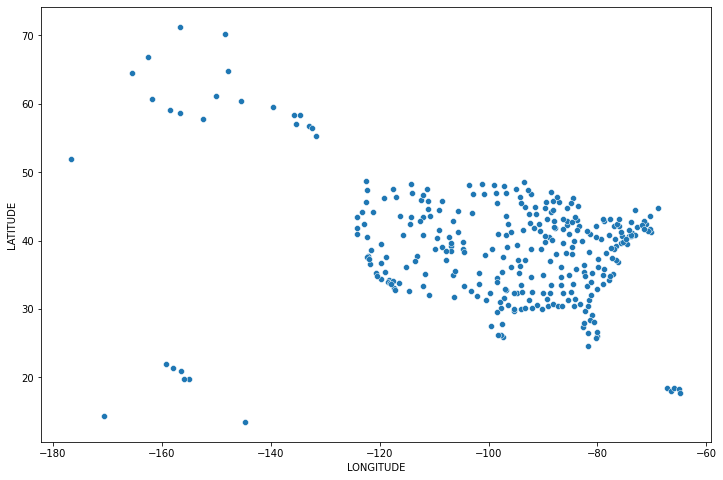

In [9]:
plt.figure(figsize=(12,8))
sns.scatterplot(x='LONGITUDE', y='LATITUDE', data=airports)
plt.show()

In [10]:
airports[airports['STATE'] == 'NY']

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
14,ALB,Albany International Airport,Albany,NY,USA,42.74812,-73.80298
29,BGM,Greater Binghamton Airport,Binghamton,NY,USA,42.20848,-75.97961
49,BUF,Buffalo Niagara International Airport,Buffalo,NY,USA,42.94052,-78.73217
99,ELM,Elmira/Corning Regional Airport,Elmira,NY,USA,42.15991,-76.89144
144,HPN,Westchester County Airport,White Plains,NY,USA,41.06696,-73.70757
150,IAG,Niagara Falls International Airport,Niagara Falls,NY,USA,43.10726,-78.94538
160,ISP,Long Island MacArthur Airport,Islip,NY,USA,40.79524,-73.10021
161,ITH,Ithaca Tompkins Regional Airport,Ithaca,NY,USA,42.49103,-76.45844
166,JFK,John F. Kennedy International Airport (New Yor...,New York,NY,USA,40.63975,-73.77893
182,LGA,LaGuardia Airport (Marine Air Terminal),New York,NY,USA,40.77724,-73.87261


In [11]:
# taking real world data for Plattsburgh International Airport:
airports.loc[234,'LATITUDE'] = 44.3903
airports.loc[234,'LONGITUDE']= -73.2805

In [12]:
airports[airports['AIRPORT'] == 'Plattsburgh International Airport']

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
234,PBG,Plattsburgh International Airport,Plattsburgh,NY,USA,44.3903,-73.2805


In [13]:
airports[airports['STATE'] == 'FL']

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
80,DAB,Daytona Beach International Airport,Daytona Beach,FL,USA,29.17992,-81.05806
96,ECP,Northwest Florida Beaches International Airport,Panama City,FL,USA,NaN,NaN
107,EYW,Key West International Airport,Key West,FL,USA,24.55611,-81.75956
114,FLL,Fort Lauderdale-Hollywood International Airport,Ft. Lauderdale,FL,USA,26.07258,-80.15275
125,GNV,Gainesville Regional Airport,Gainesville,FL,USA,29.69006,-82.27178
165,JAX,Jacksonville International Airport,Jacksonville,FL,USA,30.49406,-81.68786
193,MCO,Orlando International Airport,Orlando,FL,USA,28.42889,-81.31603
203,MIA,Miami International Airport,Miami,FL,USA,25.79325,-80.29056
206,MLB,Melbourne International Airport,Melbourne,FL,USA,28.10275,-80.64581
235,PBI,Palm Beach International Airport,West Palm Beach,FL,USA,26.68316,-80.09559


In [14]:
# taking real world data also for other two Airports:
airports.loc[96,'LATITUDE'] = 30.2130
airports.loc[96,'LONGITUDE']= -85.4744
airports.loc[313,'LATITUDE'] = 29.57333
airports.loc[313,'LONGITUDE']= -81.2023

In [15]:
df['ORIGIN_AIRPORT'].value_counts()

ATL      346836
ORD      285884
DFW      239551
DEN      196055
LAX      194673
          ...  
13541        11
10165         9
14222         9
13502         6
11503         4
Name: ORIGIN_AIRPORT, Length: 628, dtype: int64

In [16]:
airlines=pd.read_csv('airlines.csv')
airlines

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways
5,OO,Skywest Airlines Inc.
6,AS,Alaska Airlines Inc.
7,NK,Spirit Air Lines
8,WN,Southwest Airlines Co.
9,DL,Delta Air Lines Inc.


In [10]:
df['TAIL_NUMBER'].value_counts()

N480HA    3768
N488HA    3723
N484HA    3723
N493HA    3585
N478HA    3577
          ... 
N175UA       1
N852NW       1
N7LBAA       1
N7LEAA       1
N180UA       1
Name: TAIL_NUMBER, Length: 4897, dtype: int64

In [11]:
df['FLIGHT_NUMBER'].value_counts()

469     3975
327     3554
326     3513
188     3386
403     3370
        ... 
6783       1
6757       1
6752       1
6793       1
6887       1
Name: FLIGHT_NUMBER, Length: 6952, dtype: int64

In [32]:
(df['FLIGHT_NUMBER'].value_counts() == 1).sum()

38

In [12]:
df.columns

Index(['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER',
       'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
       'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT',
       'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
       'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME',
       'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
       'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY',
       'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY'],
      dtype='object')

In [13]:
# deleting columns 'FLIGHT_NUMBER', 'TAIL_NUMBER' - 
df.drop(['FLIGHT_NUMBER', 'TAIL_NUMBER'], axis=1, inplace=True)
# "AIR_SYSTEM_DELAY","SECURITY_DELAY", "AIRLINE_DELAY", "LATE_AIRCRAFT_DELAY", "WEATHER_DELAY"
df.drop(["AIR_SYSTEM_DELAY","SECURITY_DELAY", "AIRLINE_DELAY", "LATE_AIRCRAFT_DELAY", "WEATHER_DELAY"], axis=1, inplace=True)

In [14]:
# deleting Nans from columns where Nans < 2% of total records
df.dropna(subset=['DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'ELAPSED_TIME', 'AIR_TIME', 
                'WHEELS_ON', 'TAXI_IN', 'ARRIVAL_TIME', 'ARRIVAL_DELAY'], inplace=True)

In [15]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5714008 entries, 0 to 5819078
Data columns (total 24 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   YEAR                 5714008 non-null  int64  
 1   MONTH                5714008 non-null  int64  
 2   DAY                  5714008 non-null  int64  
 3   DAY_OF_WEEK          5714008 non-null  int64  
 4   AIRLINE              5714008 non-null  object 
 5   ORIGIN_AIRPORT       5714008 non-null  object 
 6   DESTINATION_AIRPORT  5714008 non-null  object 
 7   SCHEDULED_DEPARTURE  5714008 non-null  int64  
 8   DEPARTURE_TIME       5714008 non-null  float64
 9   DEPARTURE_DELAY      5714008 non-null  float64
 10  TAXI_OUT             5714008 non-null  float64
 11  WHEELS_OFF           5714008 non-null  float64
 12  SCHEDULED_TIME       5714008 non-null  float64
 13  ELAPSED_TIME         5714008 non-null  float64
 14  AIR_TIME             5714008 non-null  float64
 15

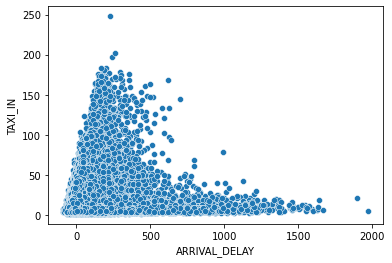

In [63]:
sns.scatterplot(x='ARRIVAL_DELAY', y='TAXI_IN', data=df)
plt.show()

In [66]:
459//100

4

In [16]:
df[['DIVERTED', 'CANCELLED', 'CANCELLATION_REASON']].info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5714008 entries, 0 to 5819078
Data columns (total 3 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   DIVERTED             5714008 non-null  int64 
 1   CANCELLED            5714008 non-null  int64 
 2   CANCELLATION_REASON  0 non-null        object
dtypes: int64(2), object(1)
memory usage: 174.4+ MB


In [17]:
df['DIVERTED'].value_counts()

0    5714008
Name: DIVERTED, dtype: int64

In [18]:
df['CANCELLED'].value_counts()

0    5714008
Name: CANCELLED, dtype: int64

In [19]:
# deleting columns 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON'
df.drop(['DIVERTED', 'CANCELLED', 'CANCELLATION_REASON'], axis=1, inplace=True)
# deleting year column
df.drop(['YEAR'], axis=1, inplace=True)

In [20]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5714008 entries, 0 to 5819078
Data columns (total 20 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   MONTH                5714008 non-null  int64  
 1   DAY                  5714008 non-null  int64  
 2   DAY_OF_WEEK          5714008 non-null  int64  
 3   AIRLINE              5714008 non-null  object 
 4   ORIGIN_AIRPORT       5714008 non-null  object 
 5   DESTINATION_AIRPORT  5714008 non-null  object 
 6   SCHEDULED_DEPARTURE  5714008 non-null  int64  
 7   DEPARTURE_TIME       5714008 non-null  float64
 8   DEPARTURE_DELAY      5714008 non-null  float64
 9   TAXI_OUT             5714008 non-null  float64
 10  WHEELS_OFF           5714008 non-null  float64
 11  SCHEDULED_TIME       5714008 non-null  float64
 12  ELAPSED_TIME         5714008 non-null  float64
 13  AIR_TIME             5714008 non-null  float64
 14  DISTANCE             5714008 non-null  int64  
 15

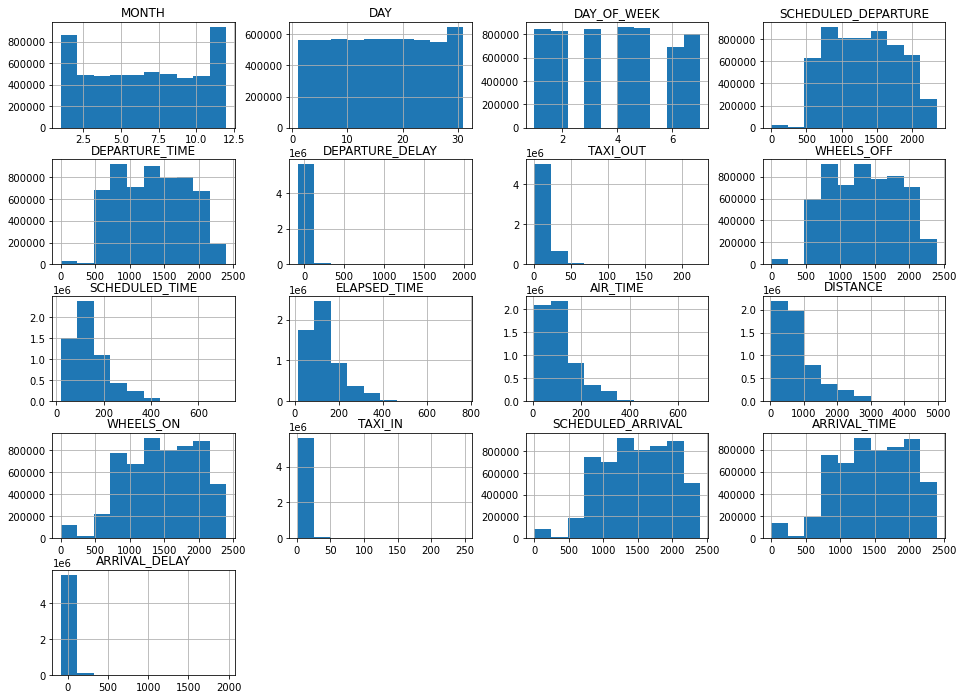

In [21]:
df.hist(figsize=(16,12))
plt.show()

<AxesSubplot:xlabel='MONTH', ylabel='ARRIVAL_DELAY'>

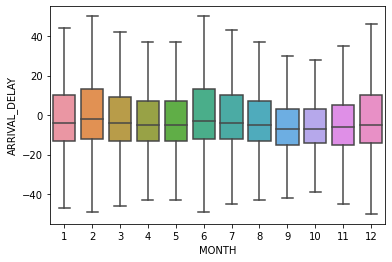

In [70]:
sns.boxplot(x='MONTH', y='ARRIVAL_DELAY', data=df, showfliers=False)
plt.show()

<AxesSubplot:xlabel='DAY_OF_WEEK', ylabel='ARRIVAL_DELAY'>

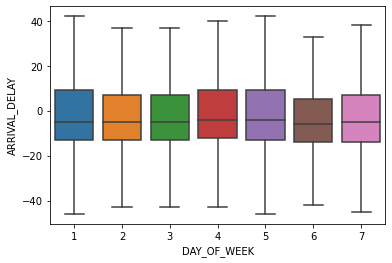

In [69]:
sns.boxplot(x='DAY_OF_WEEK', y='ARRIVAL_DELAY', data=df, showfliers=False)
plt.show()

<AxesSubplot:xlabel='AIRLINE', ylabel='ARRIVAL_DELAY'>

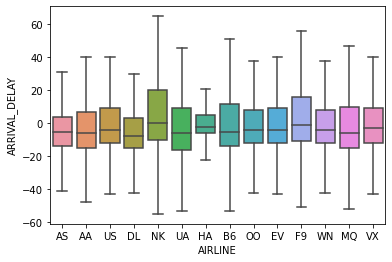

In [27]:
sns.boxplot(x='AIRLINE', y='ARRIVAL_DELAY', data=df, showfliers=False)
plt.show()

In [22]:
df.sample(10)

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY
2980201,7,6,1,VX,SEA,SFO,1700,1717.0,17.0,14.0,1731.0,125.0,122.0,102.0,679,1913.0,6.0,1905,1919.0,14.0
2316887,5,27,3,AA,DFW,SAT,1655,1650.0,-5.0,16.0,1706.0,73.0,71.0,50.0,247,1756.0,5.0,1808,1801.0,-7.0
1861743,4,29,3,EV,CLE,ORD,1139,1132.0,-7.0,10.0,1142.0,85.0,75.0,57.0,315,1139.0,8.0,1204,1147.0,-17.0
5727648,12,26,6,DL,SFO,ATL,730,806.0,36.0,32.0,838.0,271.0,286.0,248.0,2139,1546.0,6.0,1501,1552.0,51.0
868319,2,26,4,AA,MIA,BDL,2005,2009.0,4.0,28.0,2037.0,181.0,183.0,138.0,1194,2255.0,17.0,2306,2312.0,6.0
552696,2,6,5,US,PBI,CLT,1200,1152.0,-8.0,10.0,1202.0,115.0,114.0,99.0,590,1341.0,5.0,1355,1346.0,-9.0
3220991,7,20,1,WN,DEN,MCI,2045,2041.0,-4.0,9.0,2050.0,100.0,81.0,69.0,533,2259.0,3.0,2325,2302.0,-23.0
4770894,10,25,7,OO,13930,11637,1227,1223.0,-4.0,20.0,1243.0,115.0,112.0,87.0,557,1410.0,5.0,1422,1415.0,-7.0
4921442,11,4,3,WN,SMF,BUR,645,639.0,-6.0,8.0,647.0,70.0,60.0,50.0,358,737.0,2.0,755,739.0,-16.0
4582905,10,13,2,AA,11057,11618,1315,1533.0,138.0,18.0,1551.0,110.0,98.0,75.0,529,1706.0,5.0,1505,1711.0,126.0


In [ ]:
# SCHEDULED_DEPARTURE, DEPARTURE_TIME, WHEELS_OFF, WHEELS_ON, SCHEDULED_ARRIVAL, ARRIVAL_TIME
# this 6 columns shows hours and minutes from departures and arrivals

In [24]:
df['ORIGIN_AIRPORT'].value_counts()

ATL      343506
ORD      276554
DFW      232647
DEN      193402
LAX      192003
          ...  
13541        11
10165         9
14222         9
13502         6
11503         4
Name: ORIGIN_AIRPORT, Length: 628, dtype: int64